# Section 4: Getting data and some additional regression magic

This week, we are going to learn:
* How to download data from two very popular sources in the field of political economy and macroeconomics
* Look at an interesting question related to the effectiveness of international aid.
* Learn about interaction terms and bad controls
* Maybe: Make a quick example about data visualization

In [3]:
install.packages(c('WDI','owidR','plotly','showtext','huxtable','jtools'))

library('WDI')
library('owidR')
library('ggplot2')
library('dplyr')
library('plotly')
library('huxtable')
library('tidyr')
library('showtext')
library('jtools')
library('plotly')
print('Installed required packages')

# We set a seed to make sure we get the results if we run the code again, in case we generate random variables...
set.seed("1234")

Installing packages into ‘/opt/r’
(as ‘lib’ is unspecified)

also installing the dependency ‘RJSONIO’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘huxtable’


The following object is masked from ‘package:dplyr’:

    add_rownames


The following object is masked from ‘package:ggplot2’:

    theme_grey


Loading required package: sysfonts

Loading required package: showtextdb



[1] "Installed required packages"


We first download some data from the World Development Indicators (https://data.worldbank.org/). We can track down the data online and then download it using the official codes provided by the World Bank. We can filter by country and years, have a look at the data, etc.

In [4]:
dataset = WDI(indicator=c(oda_per_cap='DT.ODA.ODAT.PC.ZS',
                           perc_below_pov_line='SI.POV.DDAY',
                           gdp_per_cap_ppp='NY.GDP.PCAP.PP.CD',
                           gdp_per_cap='NY.GDP.PCAP.CD'),
               country="all",
               start=1960,
               end=2022,
               extra=TRUE)

colnames(dataset)


[1] "iso2c"               "country"             "year"               
 [4] "status"              "lastupdated"         "oda_per_cap"        
 [7] "perc_below_pov_line" "gdp_per_cap_ppp"     "gdp_per_cap"        
[10] "iso3c"               "region"              "capital"            
[13] "longitude"           "latitude"            "income"             
[16] "lending"

ERROR: Error in hist.default(dataset$gdp_pc_ppp[dataset$year == 2018]): 'x' must be numeric


,iso2c,country,year,status,lastupdated,oda_per_cap,perc_below_pov_line,gdp_per_cap_ppp,gdp_per_cap,iso3c,region,capital,longitude,latitude,income,lending
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
437,AF,Afghanistan,1960,,2022-09-16,1.909532,NA,NA,59.77323,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
446,AF,Afghanistan,1961,,2022-09-16,3.781052,NA,NA,59.86090,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
447,AF,Afghanistan,1962,,2022-09-16,1.810416,NA,NA,58.45801,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
448,AF,Afghanistan,1963,,2022-09-16,3.842526,NA,NA,78.70643,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
449,AF,Afghanistan,1964,,2022-09-16,4.737925,NA,NA,82.09531,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
450,AF,Afghanistan,1965,,2022-09-16,5.416661,NA,NA,101.10833,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   285.3   2947.8   7692.0  14597.4  19250.6 153563.9     9023 

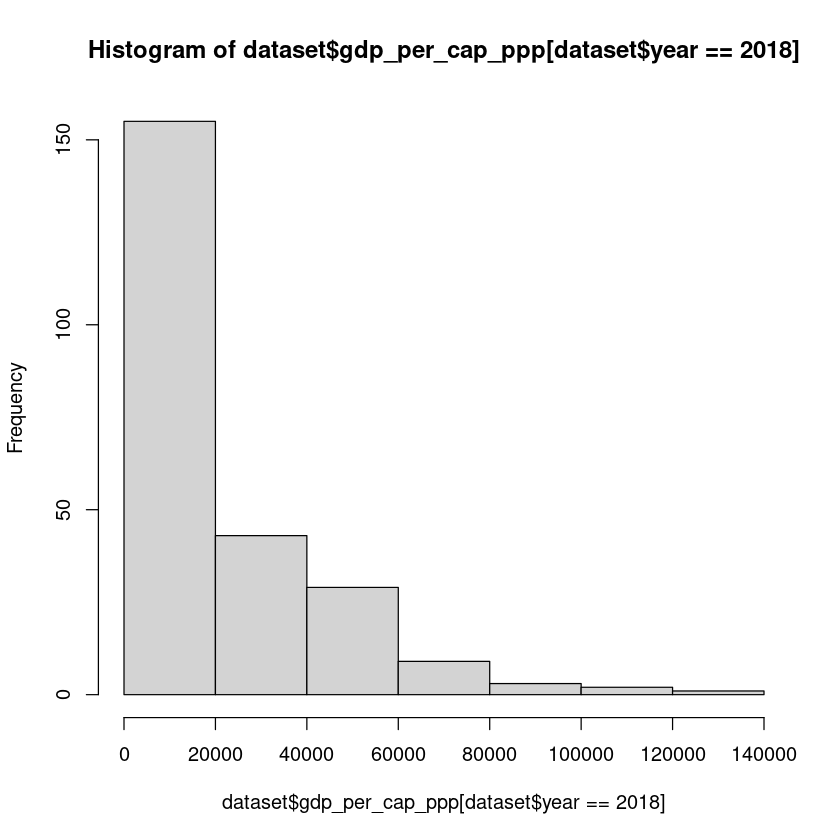

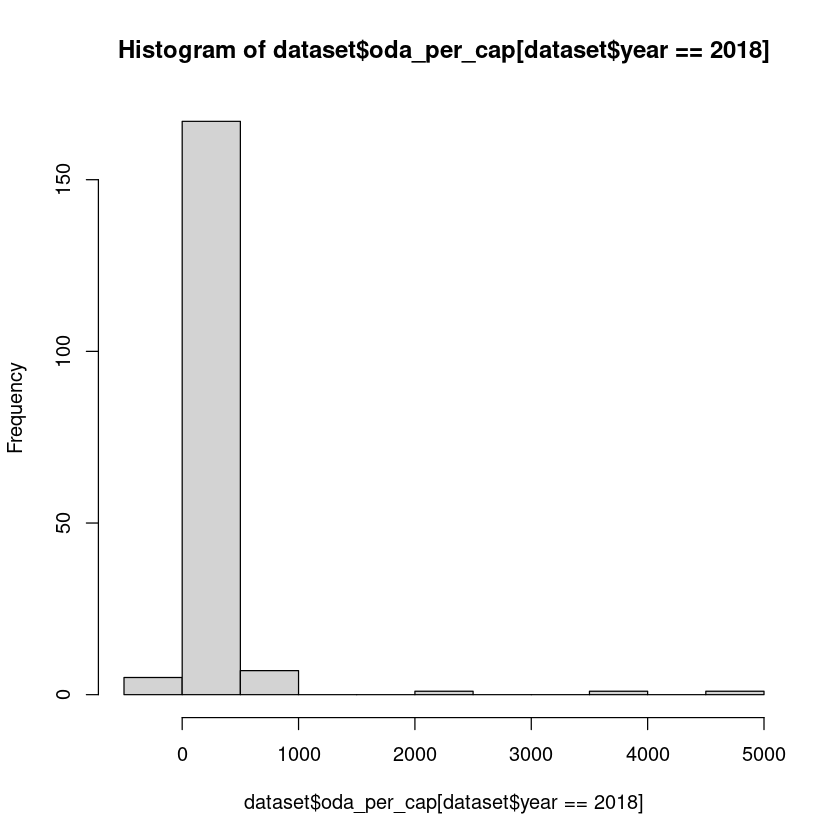

In [10]:
head(dataset)
dataset = dataset[order(dataset$country, dataset$year),]
summary(dataset$gdp_per_cap_ppp)


hist(dataset$gdp_per_cap_ppp[dataset$year==2018])
hist(dataset$oda_per_cap[dataset$year==2018])



Some of the data have missing values in some years. Today, we will solve this pragmatically by just using the previous years' values if an observation is missing. We have to do this _grouped by country_.


In [11]:
dataset = dataset %>% 
  group_by(iso3c) %>%
      fill(perc_below_pov_line, .direction = "down")

dataset = dataset %>% 
  group_by(iso3c) %>%
  fill(oda_per_cap, .direction = "down")

dataset = dataset %>% 
  group_by(iso3c) %>%
  fill(gdp_per_cap_ppp, .direction = "down")

We are interested in whether the effect of international aid (ODA - official development assistance) is different in countries with democracies vs. in non-democratic countries. For this we need data on demcracy. We will also get data from schooling for some later analysis. We can get this from https://ourworldindata.org/. 

We can first search for terms using the search engine in the package. Next, we can read in the data, rename it, and filter by years (and countries, if we want to).

In [ ]:
owid_search("democracy")

democracy <- owid("democracy-polity",
                  rename = "democracy") %>% 
  filter(year %in% 1960:2018)


owid_search("schooling")
yos <- owid("mean-years-of-schooling-long-run",
                  rename = "years_of_schooling") %>% 
  filter(year %in% 1960:2018)


The next thing we want to do is to combine these two datasets. We can do this by a process called **merging** the data. We need to have at least one column of data that have the same identifier (for example, survey ID number, country name, year, etc.). We merge with the command `join` and we can do a `right_join` in this case because we want complete observations in the democracy data.

In [13]:

democracy$country = democracy$entity
democracy$iso3c = democracy$code 

yos$country = yos$entity
yos$iso3c = yos$code

dataset_panel <- dataset %>% 
  right_join(democracy)

dataset_panel <- dataset_panel %>% 
  left_join(yos)


Joining, by = c("country", "year", "iso3c")
Joining, by = c("country", "year", "iso3c", "entity", "code")


Next, we have to do some data cleaning and generate some additional variables. I will largely skip over this. (Note: The main problem is that we now have a _panel_ (countryXyear)( dataset, which we haven't talked about in class yet. I will convert this into a _cross-sectional_ dataset, which only has one observation (year) per unit (country) of analysis. We will talk about the exciting world of panel datasets later in class!)

In [15]:
head(dataset_panel)

# Normalize democracy scores
dataset_panel$democracy = (dataset_panel$democracy+10)/20

# Generate cross-sectional data
dataset_cs = dataset_panel %>%
  filter(year==2016)

# Make year averages
data_pov90s = dataset_panel %>%
  filter(year %in% 1970:1990) %>%
  group_by(iso3c) %>%
  dplyr::summarize(pov_1990s = mean(perc_below_pov_line, na.rm=TRUE))

data_pov10s = dataset_panel %>%
  filter(year %in% 2010:2020) %>%
  group_by(iso3c) %>%
  dplyr::summarize(pov_2010s = mean(perc_below_pov_line, na.rm=TRUE))

data_aid9010 = dataset_panel %>%
  filter(year %in% 1990:2010) %>%
  group_by(iso3c) %>%
  dplyr::summarize(aid_9010 = mean(oda_per_cap, na.rm=TRUE))

data_aid1015 = dataset_panel %>%
  filter(year %in% 2010:2015) %>%
  group_by(iso3c) %>%
  dplyr::summarize(aid_1015 = mean(oda_per_cap, na.rm=TRUE))


data_dem9010 = dataset_panel %>%
  filter(year %in% 1990:2010) %>%
  group_by(iso3c) %>%
  dplyr::summarize(dem9010 = mean(democracy, na.rm=TRUE))


data_gdp1970= dataset_panel %>%
  filter(year %in% 1970) %>%
  group_by(iso3c) %>%
  dplyr::summarize(gdp1970 = mean(gdp_per_cap, na.rm=TRUE))


# Merge in year-averages
dataset_cs = dataset_cs %>% 
  left_join(data_pov90s)

dataset_cs = dataset_cs %>% 
  left_join(data_pov10s)

dataset_cs = dataset_cs %>% 
  left_join(data_aid9010)

dataset_cs = dataset_cs %>% 
  left_join(data_dem9010)

dataset_cs = dataset_cs %>% 
  left_join(data_gdp1970)

dataset_cs = dataset_cs %>% 
  left_join(data_aid1015)

# Generate happiness variable
dataset_cs$happiness = dataset_cs$gdp_per_cap_ppp + rnorm(nrow(dataset_cs),0,1000)


iso2c,country,year,status,lastupdated,oda_per_cap,perc_below_pov_line,gdp_per_cap_ppp,gdp_per_cap,iso3c,region,capital,longitude,latitude,income,lending,entity,code,democracy,years_of_schooling
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
AF,Afghanistan,1960,,2022-09-16,1.909532,NA,NA,59.77323,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,0.22
AF,Afghanistan,1961,,2022-09-16,3.781052,NA,NA,59.86090,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,NA
AF,Afghanistan,1962,,2022-09-16,1.810416,NA,NA,58.45801,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,NA
AF,Afghanistan,1963,,2022-09-16,3.842526,NA,NA,78.70643,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,NA
AF,Afghanistan,1964,,2022-09-16,4.737925,NA,NA,82.09531,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.15,NA
AF,Afghanistan,1965,,2022-09-16,5.416661,NA,NA,101.10833,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.15,0.29


Joining, by = "iso3c"
Joining, by = "iso3c"
Joining, by = "iso3c"
Joining, by = "iso3c"
Joining, by = "iso3c"
Joining, by = "iso3c"


## Analysis: Analyzing interaction terms
Last week, I gave a hint that we will talk about interaction terms. Interaction terms can help us to understand questions such as:
* Does having a child have a **different effect** on wages for men and women?
* Do children from different socio-economic backgrounds **respond differently** to free school meals?
* Does development aid **work better** in democratic as opposed to non-democratic countries?

We quickly analyze the math of this model on the blackboard.

Let's run the regression!

In [23]:
summary(nointeraction <- lm(pov_2010s ~ pov_1990s +  aid_9010 + dem9010 , data=dataset_cs))

summary(interaction <- lm(pov_2010s ~ pov_1990s +  aid_9010 + dem9010 + I(aid_9010*dem9010), data=dataset_cs))

summary(nointeraction_gdp <- lm(gdp_per_cap_ppp ~ pov_1990s +  aid_9010 + dem9010 , data=dataset_cs))

summary(interaction_gdp <- lm(gdp_per_cap_ppp ~  pov_1990s +  aid_9010 + dem9010 + I(aid_9010*dem9010), data=dataset_cs))


export_summs(nointeraction, interaction, nointeraction_gdp, interaction_gdp)



Call:
lm(formula = pov_2010s ~ pov_1990s + aid_9010 + dem9010, data = dataset_cs)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.557  -6.029  -2.393   0.351  58.205 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -48.54936  124.86619  -0.389 0.700074    
pov_1990s     0.44900    0.11769   3.815 0.000609 ***
aid_9010      0.02710    0.04524   0.599 0.553423    
dem9010      89.17556  231.48495   0.385 0.702696    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.06 on 31 degrees of freedom
  (138 observations deleted due to missingness)
Multiple R-squared:  0.3263,	Adjusted R-squared:  0.2611 
F-statistic: 5.006 on 3 and 31 DF,  p-value: 0.006035



Call:
lm(formula = pov_2010s ~ pov_1990s + aid_9010 + dem9010 + I(aid_9010 * 
    dem9010), data = dataset_cs)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.642  -6.578  -2.510   0.934  58.074 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -110.1740   175.9525  -0.626  0.53595    
pov_1990s                0.4611     0.1215   3.794  0.00067 ***
aid_9010                 1.6173     3.1589   0.512  0.61242    
dem9010                202.8535   325.4113   0.623  0.53775    
I(aid_9010 * dem9010)   -2.9569     5.8734  -0.503  0.61833    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.25 on 30 degrees of freedom
  (138 observations deleted due to missingness)
Multiple R-squared:  0.332,	Adjusted R-squared:  0.2429 
F-statistic: 3.727 on 4 and 30 DF,  p-value: 0.01408



Call:
lm(formula = gdp_per_cap_ppp ~ pov_1990s + aid_9010 + dem9010, 
    data = dataset_cs)

Residuals:
    Min      1Q  Median      3Q     Max 
-9889.8 -4212.9  -731.3  3049.1 15632.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -98083.75   50054.78  -1.960  0.05910 . 
pov_1990s     -170.44      47.18  -3.613  0.00106 **
aid_9010        34.37      18.13   1.895  0.06738 . 
dem9010     213105.91   92794.76   2.297  0.02856 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6436 on 31 degrees of freedom
  (138 observations deleted due to missingness)
Multiple R-squared:  0.4931,	Adjusted R-squared:  0.4441 
F-statistic: 10.05 on 3 and 31 DF,  p-value: 8.77e-05



Call:
lm(formula = gdp_per_cap_ppp ~ pov_1990s + aid_9010 + dem9010 + 
    I(aid_9010 * dem9010), data = dataset_cs)

Residuals:
     Min       1Q   Median       3Q      Max 
-10317.4  -3906.2   -207.2   3496.2  10720.6 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             5758.34   65378.24   0.088 0.930400    
pov_1990s               -190.89      45.16  -4.227 0.000204 ***
aid_9010               -2645.16    1173.73  -2.254 0.031684 *  
dem9010                21549.99  120912.30   0.178 0.859742    
I(aid_9010 * dem9010)   4982.67    2182.35   2.283 0.029675 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6039 on 30 degrees of freedom
  (138 observations deleted due to missingness)
Multiple R-squared:  0.5682,	Adjusted R-squared:  0.5106 
F-statistic: 9.868 on 4 and 30 DF,  p-value: 3.223e-05


,names,Model 1,Model 2,Model 3,Model 4
,<chr>,<chr>,<chr>,<chr>,<chr>
,,Model 1,Model 2,Model 3,Model 4
1,(Intercept),-48.5493550591594,-110.173956969703,-98083.7509840379,5758.34395016852
2,,(124.866186099309),(175.952484472509),(50054.7797988006),(65378.2351936685)
3,pov_1990s,0.449003445297354 ***,0.461139959245197 ***,-170.439486392024 **,-190.890426348954 ***
4,,(0.117688004242321),(0.121545788104838),(47.1772809063344),(45.1624718192567)
5,aid_9010,0.0271043531973337,1.61726254199136,34.3734403041819,-2645.16285659322 *
6,,(0.0452375495391137),(3.1588632761914),(18.1342575724767),(1173.73111743558)
7,dem9010,89.1755599130882,202.853517651617,213105.912540088 *,21549.9930950116
8,,(231.484946648272),(325.411338684543),(92794.7620823547),(120912.296856647)


## Bad controls
When we talked about omitted variables, we always talked about how forgetting an important variable can have bad consequences for your analysis. But there is also the opposite problem: Bad controls!
The bad controls problem arises when we control for a variable in a regression that is actually an outcome (a variable on the left-hand side). 

For example:
* A treatment gives people money at time t, and we want to study how it changes their consumption at time t+1. We control for their wage at time t+1.
* We want to study whether winning the lottery at time t makes you happier at time t+1. We control for whether you bought a Ferrari at time t+1.

Let's make an example. We know that happiness is strongly related to income (at least, to some extent: https://ourworldindata.org/happiness-and-life-satisfaction ). Aid in the past will affect income today and happiness today. Therefore, controlling for happiness today introduces a bad control problem!

In [26]:

summary(basic_regression <- lm( gdp_per_cap_ppp ~  gdp1970 +  aid_9010, data=dataset_cs))

summary(bad_controls <- lm( gdp_per_cap_ppp ~  gdp1970 +  aid_9010 + happiness, data=dataset_cs))

export_summs(basic_regression, bad_controls)



Call:
lm(formula = gdp_per_cap_ppp ~ gdp1970 + aid_9010, data = dataset_cs)

Residuals:
   Min     1Q Median     3Q    Max 
-20091  -4887  -3012   2724  67405 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8980.844   2349.727   3.822 0.000287 ***
gdp1970       14.526      2.611   5.565 4.66e-07 ***
aid_9010     -87.215     43.529  -2.004 0.049039 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10630 on 69 degrees of freedom
  (101 observations deleted due to missingness)
Multiple R-squared:  0.3831,	Adjusted R-squared:  0.3652 
F-statistic: 21.43 on 2 and 69 DF,  p-value: 5.782e-08



Call:
lm(formula = gdp_per_cap_ppp ~ gdp1970 + aid_9010 + happiness, 
    data = dataset_cs)

Residuals:
    Min      1Q  Median      3Q     Max 
-2280.8  -758.0  -102.5   829.6  2438.0 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 328.2703   256.2511   1.281    0.205    
gdp1970      -0.4513     0.3166  -1.426    0.159    
aid_9010     -7.1480     4.4423  -1.609    0.112    
happiness     1.0038     0.0121  82.976   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1059 on 68 degrees of freedom
  (101 observations deleted due to missingness)
Multiple R-squared:  0.994,	Adjusted R-squared:  0.9937 
F-statistic:  3734 on 3 and 68 DF,  p-value: < 2.2e-16


,names,Model 1,Model 2
,<chr>,<chr>,<chr>
,,Model 1,Model 2
1,(Intercept),8980.84418750174 ***,328.270260553971
2,,(2349.72684697548),(256.251118001714)
3,gdp1970,14.5264650663476 ***,-0.451308983370634
4,,(2.61052430571508),(0.316561132640213)
5,aid_9010,-87.2151305690128 *,-7.14796293401853
6,,(43.5286509202041),(4.44229039827936)
7,happiness,,1.00378050801588 ***
8,,,(0.0120971978645767)


We can interpret bad controls through the OVB formula we learnt last time:

$$ \rho_s = \rho + \gamma \cdot \delta $$

where $\rho$ is the "long" coefficient, $\gamma$ is the coefficient of the omitted variable in the long regression, $\delta$ is the coefficient in the auxiliary regression (regress omitted variable on included variable), and $\rho_s$ is the "short" regression coefficient.

Remember? It told you that this formula **ALWAYS** holds - no matter what variable I include. 

Extreme case: Include GDP$\times$10 on the RHS - what will happen?

## Do you need an OVB revision?

In [29]:
# Revise OVB
a = lm(log(gdp_per_cap_ppp) ~  democracy  , data=dataset_cs)
b = lm(log(gdp_per_cap_ppp) ~ years_of_schooling +  democracy  , data=dataset_cs)
c = lm(years_of_schooling  ~ democracy  , data=dataset_cs)
export_summs(a,b,c)

,names,Model 1,Model 2,Model 3
,<chr>,<chr>,<chr>,<chr>
,,Model 1,Model 2,Model 3
1,(Intercept),1.09009171786149,8.96440800542877 ***,-25.4438428120716 **
2,,(3.5845626524535),(1.94872769203634),(8.62215636672122)
3,democracy,15.2527368966298 *,-4.28199504589645,63.1104742397464 ***
4,,(6.67806650043998),(3.69542563257363),(16.0966995706918)
5,years_of_schooling,,0.313394531780118 ***,
6,,,(0.0166755807608285),
1.1,N,145,144,162
2.1,R2,0.035196299293719,0.725080867999958,0.0876534587488709


## Data visualizations
An important skill - this is just a quick example and we'll do more in the next weeks!

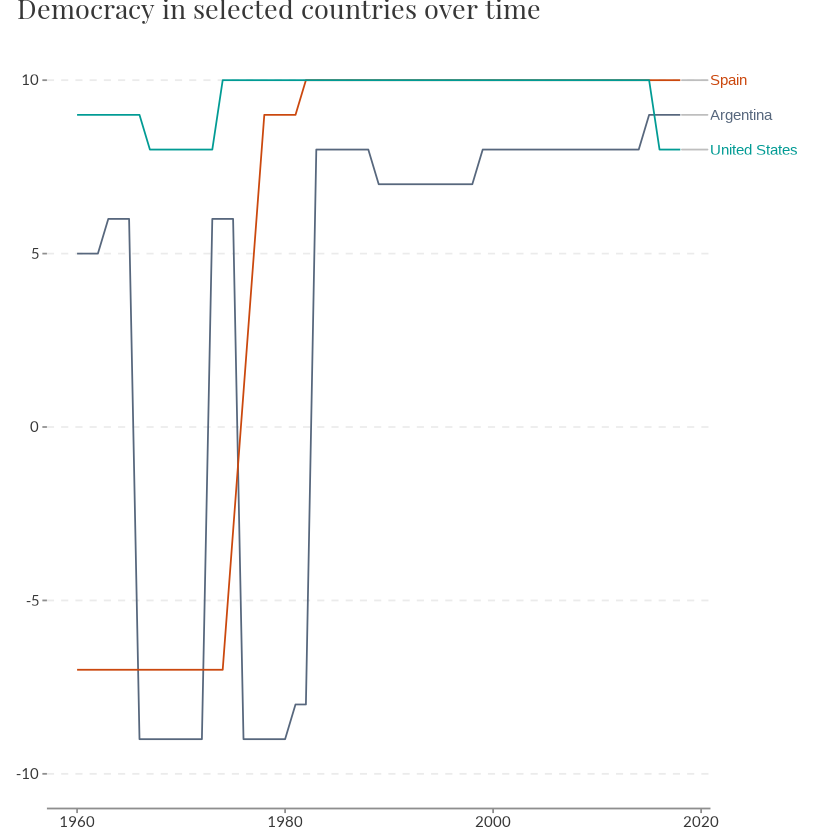

In [30]:
a = c("Argentina","Spain", "United States")
owid_plot(democracy, filter = a, summarise=FALSE) +
  labs(title = paste0("Democracy in selected countries over time")) +
  scale_y_continuous(limits = c(-10, 10))


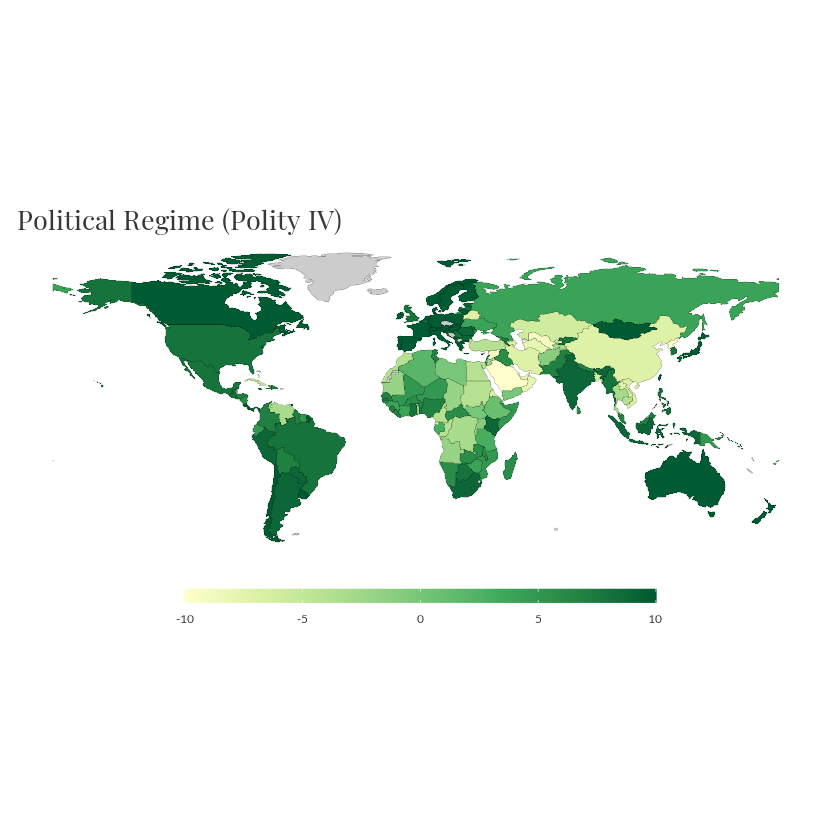

In [32]:
# Make a map

democracy2 <- owid("democracy-polity",
                   rename = "democracy") %>% 
  filter(year==2018)

owid_map(democracy2, palette = "YlGn") +
  labs(title = "Political Regime (Polity IV)")